# Compare Inference models for Protein Contacts using DCA
The purpose of this python notebook is to concisely compare several inferences models which all use Direct Coupling Analysis (DCA) to infer contact information for Multiple Sequence Alignments (MSA) of homologous protein families.

### Methods
* Mean Field (mfDCA)
* Pseudoliklihood (plmDCA)
* Expectation Reflection (erDCA)

In [1]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info
from direct_info import sort_di
import data_processing as dp

import Bio.PDB, warnings
from Bio.PDB.Polypeptide import PPBuilder
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline


import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

# import inference_dca for mfDCA
from inference_dca import direct_info_dca

# import pydca for plmDCA
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities

tools.hide_toggle()

## Read In Protein Structure

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF04542'
pfam_id = "PF00010" # No PDB structure
pfam_id = "PF00011"
pfam_id = 'PF00186'


pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# Pre-Process Structure Data
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
print(df.head())

ipdb = 0
print('seq #:',int(pdb[ipdb,1]))
print('pdb row: ', pdb[ipdb,:])


# Read in Sequence Data
processing = True
if processing:
    # data processing
    
    s0,cols_removed,s_index,s_ipdb = dp.data_processing(data_path=data_path,pfam_id=pfam_id,ipdb=ipdb,\
                    gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)
    # Save processed data
    msa_outfile, ref_outfile = dp.write_FASTA(s0,pfam_id,s_ipdb)
else:
    msa_outfile, ref_outfile = dp.create_unprocessed_FASTA(pdb,data_path,pfam_id,ipdb)
    
    # create MSATrimmer instance 
    trimmer = msa_trimmer.MSATrimmer(
        msa_outfile, biomolecule='protein', 
        refseq_file=ref_outfile,
    )

    trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)
    print ("trimmed_data:\n",trimmed_data)

    #write trimmed msa to file in FASTA format
    trimmed_data_outfile = 'MSA_'+pfam_id+'_Trimmed.fa'
    with open(trimmed_data_outfile, 'w') as fh:
        for seqid, seq in trimmed_data:
            fh.write('>{}\n{}\n'.format(seqid, seq))
            
            
#----------------CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAG-CCUUAAA-CUCUUGAUUAUGAAGUG-------------
#CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUGAAGUG
#UGAAAUUGGAUAACAGUUUUUCGUAUAAUCUCGGGAAU-UGGCCUGAGAGUUUCUACGAGAUCACCGCAAAUGAUCUGGCUACGAAAAAAAGGAACGGUAUC
tools.hide_toggle()



number of pdb structures: 372
        PF seq            id uniprot_start uniprot_start pdb_id chain  \
0  PF00186  69  Q5KZ26_GEOKA             1           160   1ZDR     B   
1  PF00186  69  Q5KZ26_GEOKA             1           160   1ZDR     A   
2  PF00186  83  Q81R22_BACAN             2           160   3JWK     B   
3  PF00186  83  Q81R22_BACAN             2           160   3S9U     B   
4  PF00186  83  Q81R22_BACAN             2           160   3FL9     H   

  pdb_start pdb_end  
0         1     160  
1         1     160  
2         2     160  
3         2     160  
4         2     160  
seq #: 69
pdb row:  ['PF00186' '69' 'Q5KZ26_GEOKA' '1' '160' '1ZDR' 'B' '1' '160']
shape of s (import from msa.npy):
 (7750, 918)
shape of s (after UTF-8 decode):
 (7750, 918)
pdb:
 [[b'PF00186' b'69' b'Q5KZ26_GEOKA' ... b'B' b'1' b'160']
 [b'PF00186' b'69' b'Q5KZ26_GEOKA' ... b'A' b'1' b'160']
 [b'PF00186' b'83' b'Q81R22_BACAN' ... b'B' b'2' b'160']
 ...
 [b'PF00186' b'6952' b'DYR_MYCTU' ... b'A



## Expectation Reflection DCA (erDCA)
* Generate One-Hot matrix representation of sequence data
* Generate and plot Contact Map

Structure exists: '/home/eclay/DCA_ER/zd/pdb1zdr.ent' 
1366
(137, 3)
Structure exists: '/home/eclay/DCA_ER/zd/pdb1zdr.ent' 
peptide build of chain produced 1 elements
(137, 3)


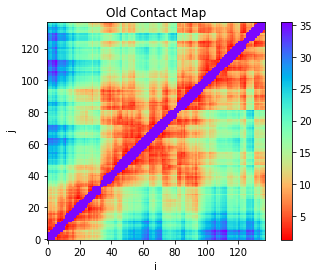

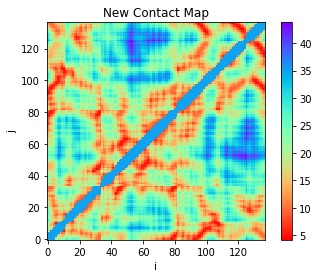

In [3]:
# number of positions
n_var = s0.shape[1]

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

# number of variables
mx_sum = mx.sum()

# number of bias term
n_linear = mx_sum - n_var

#---------------------- Generate One-Hot/Contact -------------------#
# Generate One-Hot Matrix
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)

# Generate Contact Map
ct_old = tools.contact_map(pdb,ipdb,cols_removed,s_index,use_old=True)
ct_old = tools.distance_restr(ct_old,s_index,make_large=True)

ct = tools.contact_map(pdb,ipdb,cols_removed,s_index)
ct_distal = tools.distance_restr(ct,s_index,make_large=True)
#--------------------------------------------------------------------#
plt.title('Old Contact Map')
plt.imshow(ct_old,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

plt.title('New Contact Map')
plt.imshow(ct_distal,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

tools.hide_toggle()

#### Apply Expectation Reflection

In [4]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

In [5]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
res = Parallel(n_jobs = 4)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('ER run time:',run_time)

#-------------------------------

for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w = (w + w.T)/2.

tools.hide_toggle()

ER run time: 460.32540131598944


#### Calculate Direct Info from erDCA

In [6]:
#print(w[:10,-10:])
di_er = direct_info(s0,w)
#sorted_DI_er = sorted_DI_er[::2]
sorted_DI_ER_redundant = sort_di(di_er)
print("Print top 10 pairs")
for x in sorted_DI_ER_redundant[:10]:
    print(x)

from data_processing import delete_sorted_DI_duplicates # newly generated for this python notebook.
sorted_DI_er = delete_sorted_DI_duplicates(sorted_DI_ER_redundant)

sorted_DI_er_dr = tools.distance_restr_sortedDI(sorted_DI_er)

print("\nPrint top 10 Non-Redundant pairs")
for x in sorted_DI_er[:10]:
    print(x)
print("\nPrint top 10 Non-Redundant DR pairs")
for x in sorted_DI_er_dr[:10]:
    print(x)

Print top 10 pairs
((10, 105), 0.29478476823373495)
((105, 10), 0.29478476823373495)
((39, 38), 0.1918241374969438)
((38, 39), 0.1918241374969438)
((43, 28), 0.16726780485887444)
((28, 43), 0.16726780485887444)
((60, 44), 0.16281707795560002)
((44, 60), 0.16281707795560002)
((32, 45), 0.1465647158713814)
((45, 32), 0.1465647158713814)

Print top 10 Non-Redundant pairs
((10, 105), 0.29478476823373495)
((39, 38), 0.1918241374969438)
((43, 28), 0.16726780485887444)
((60, 44), 0.16281707795560002)
((32, 45), 0.1465647158713814)
((6, 10), 0.14546217169935077)
((120, 117), 0.14464996951380008)
((48, 84), 0.14342700501530933)
((12, 11), 0.13020691275942448)
((100, 7), 0.12482568512944693)

Print top 10 Non-Redundant DR pairs
((10, 105), 0.29478476823373495)
((43, 28), 0.16726780485887444)
((60, 44), 0.16281707795560002)
((32, 45), 0.1465647158713814)
((48, 84), 0.14342700501530933)
((100, 7), 0.12482568512944693)
((30, 79), 0.12403808846043973)
((97, 4), 0.11486256716445056)
((65, 88), 0.1146

## Mean Field DCA (mfDCA)

In [7]:

#create mean-field DCA instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    msa_outfile,
    'protein',
    pseudocount = 0.5,
    seqid = 0.8,

)

#start_time = timeit.default_timer()
#di_mf = direct_info_dca(s0)
#run_time = timeit.default_timer() - start_time
#print('MF run time:',run_time)

# Compute DCA scores using Mean Field DCA
start_time = timeit.default_timer()
sorted_DI_mf = mfdca_inst.compute_sorted_DI()
run_time = timeit.default_timer() - start_time
print('MF run time:',run_time)

N = mfdca_inst.sequences_len
B = mfdca_inst.num_sequences
print("sorted_DI (list) has shape: ",np.array(sorted_DI_mf).shape,"\nRows: all combinations of sequence postitions ie sequence len choose 2 ")
print("num sequences = %d , sequences len = %d\n\n"%(B,N))



print("Print top 10 pairs")
for site_pair, score in sorted_DI_mf[:10]:
    print(site_pair, score)

print("\nPrint top 10 pairs (Distance Restraint)")
sorted_DI_mf_dr = tools.distance_restr_sortedDI(sorted_DI_mf)
for site_pair, score in sorted_DI_mf_dr[:10]:
    print(site_pair, score)
    
# Generate Direct Information matrix
di_mf = np.zeros((N,N))
DI_ver= np.array(sorted_DI_mf)

for coupling in sorted_DI_mf:
    di_mf[coupling[0][0],coupling[0][1]] = coupling[1]
    di_mf[coupling[0][1],coupling[0][0]] = coupling[1]

print("Calculated DI: (shape, matrix)\n",di_mf.shape,"\n",di_mf)
np.save("mfDCA_DI_%s.npy"%(pfam_id),di_mf)


tools.hide_toggle()

MF run time: 34.14454980302253
sorted_DI (list) has shape:  (9316, 2) 
Rows: all combinations of sequence postitions ie sequence len choose 2 
num sequences = 6608 , sequences len = 137


Print top 10 pairs
(10, 105) 0.400230301923111
(44, 60) 0.2923849842423396
(117, 120) 0.2816929192554315
(4, 5) 0.2612883605234514
(6, 10) 0.23237616028629288
(38, 39) 0.22274717143225525
(28, 43) 0.20416091625519348
(7, 100) 0.19226906729736554
(125, 126) 0.19121033038659188
(4, 108) 0.19004580238017243

Print top 10 pairs (Distance Restraint)
(10, 105) 0.400230301923111
(44, 60) 0.2923849842423396
(28, 43) 0.20416091625519348
(7, 100) 0.19226906729736554
(4, 108) 0.19004580238017243
(30, 79) 0.18107129008512565
(32, 45) 0.1650444607968694
(1, 96) 0.14776301643459455
(35, 59) 0.14097478966381702
(16, 105) 0.14076172164185555
Calculated DI: (shape, matrix)
 (137, 137) 
 [[0.         0.06417916 0.01800974 ... 0.00524297 0.00427512 0.00080854]
 [0.06417916 0.         0.03996646 ... 0.00970639 0.01562214

## Pseudoliklihood DCA (plmDCA)

In [8]:
# DCA scores using Pseudolikelihood maximization algorithm        
plmdca_inst = plmdca.PlmDCA(
    msa_outfile,
    'protein',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads = 10,
    max_iterations = 500,
)

# Compute DCA scores using Pseudolikelihood maximization algorithm
start_time = timeit.default_timer()
sorted_DI_plm = plmdca_inst.compute_sorted_DI()
run_time = timeit.default_timer() - start_time
print('PLM run time:',run_time)

N = plmdca_inst.sequences_len
B = plmdca_inst.num_sequences
print("sorted_DI (list) has shape: ",np.array(sorted_DI_plm).shape,"\nRows: all combinations of sequence postitions ie sequence len choose 2 ")
print("num sequences = %d , sequences len = %d\n\n"%(B,N))

print("Print top 10 pairs")
for site_pair, score in sorted_DI_plm[:10]:
    print(site_pair, score)

print("\nPrint top 10 pairs (Distance Restraint)")
sorted_DI_plm_dr = tools.distance_restr_sortedDI(sorted_DI_plm)
for site_pair, score in sorted_DI_plm_dr[:10]:
    print(site_pair, score)
    
tools.hide_toggle()

PLM run time: 511.8541458559921
sorted_DI (list) has shape:  (9316, 2) 
Rows: all combinations of sequence postitions ie sequence len choose 2 
num sequences = 6734 , sequences len = 137


Print top 10 pairs
(10, 105) 0.09961124510616264
(28, 43) 0.08011595167813336
(44, 60) 0.07788974006260006
(117, 120) 0.06534680535972026
(7, 100) 0.06061548709403337
(38, 39) 0.05776772726974384
(11, 12) 0.05702788050882394
(65, 88) 0.04904016575400982
(30, 79) 0.04410316417008284
(24, 27) 0.04300012568225258

Print top 10 pairs (Distance Restraint)
(10, 105) 0.09961124510616264
(28, 43) 0.08011595167813336
(44, 60) 0.07788974006260006
(7, 100) 0.06061548709403337
(65, 88) 0.04904016575400982
(30, 79) 0.04410316417008284
(32, 45) 0.04161526333506831
(36, 54) 0.04065062177371168
(4, 97) 0.038544386558160684
(50, 83) 0.0366193714317287


In [9]:
# Generate Direct Information matrix
di_plm = np.zeros((N,N))
DI_ver= np.array(sorted_DI_plm)


for coupling in sorted_DI_er:
    di_plm[coupling[0][0],coupling[0][1]] = coupling[1]
    di_plm[coupling[0][1],coupling[0][0]] = coupling[1]
print("Calculated DI: (shape, matrix)\n",di_plm.shape,"\n",di_plm)
np.save("plmDCA_DI_%s.npy"%(pfam_id),di_plm)

Calculated DI: (shape, matrix)
 (137, 137) 
 [[0.         0.11903612 0.01959786 ... 0.00552791 0.00511211 0.00659808]
 [0.11903612 0.         0.02547193 ... 0.00516465 0.01010167 0.00995601]
 [0.01959786 0.02547193 0.         ... 0.00531149 0.00550317 0.00801922]
 ...
 [0.00552791 0.00516465 0.00531149 ... 0.         0.04158259 0.10593951]
 [0.00511211 0.01010167 0.00550317 ... 0.04158259 0.         0.09375394]
 [0.00659808 0.00995601 0.00801922 ... 0.10593951 0.09375394 0.        ]]


## Plot ROC, AUC, and Precision for all Methods
* Vary contact threshold for each method to find optimal contact prediction for each model
* Plot resulting ROC, AUC, and Precision

In [10]:
# DCA_di = direct_info_dca(s0)
# #sorted_DI_er = sorted_DI_er[::2]
# sorted_DI_mf = sort_di(DCA_di)
# print("Print top 10 pairs")
# for site_pair, score in sorted_DI_mf[:10]:
#     print(site_pair, score)

di_er shape =  (137, 137)
di_mf shape =  (137, 137)
di_plm shape =  (137, 137)


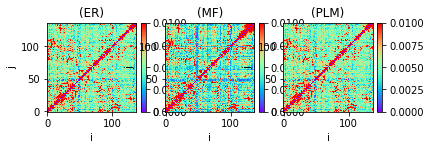

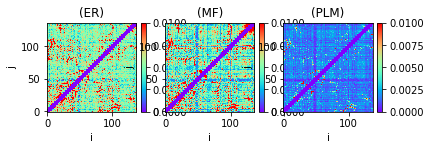

In [18]:
print("di_er shape = ",di_er.shape)
print("di_mf shape = ",di_mf.shape)
print("di_plm shape = ",di_plm.shape)

plt.subplot2grid((1,3),(0,0))
plt.title('(ER)')
plt.imshow(di_er,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.subplot2grid((1,3),(0,1))
plt.title('(MF)')
plt.imshow(di_mf,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.subplot2grid((1,3),(0,2))
plt.title('(PLM)')
plt.imshow(di_plm,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

distance_enforced = True
if distance_enforced:
    # Generate Direct Information matrix
    di_er_dr = np.zeros((N,N))
    di_mf_dr = np.zeros((N,N))
    di_plm_dr = np.zeros((N,N))
    #di_er_dr = tools.distance_restr(di_er,s_index,make_large=False)
    #di_mf_dr = tools.distance_restr(di_mf,s_index,make_large=False)
    #di_plm_dr = tools.distance_restr(di_plm,s_index,make_large=False)
    for coupling in sorted_DI_er_dr:
        di_er_dr[coupling[0][0],coupling[0][1]] = coupling[1]
        di_er_dr[coupling[0][1],coupling[0][0]] = coupling[1]
    for coupling in sorted_DI_mf_dr:
        di_mf_dr[coupling[0][0],coupling[0][1]] = coupling[1]
        di_mf_dr[coupling[0][1],coupling[0][0]] = coupling[1]
    for coupling in sorted_DI_plm_dr:
        di_plm_dr[coupling[0][0],coupling[0][1]] = coupling[1]
        di_plm_dr[coupling[0][1],coupling[0][0]] = coupling[1]
        

plt.subplot2grid((1,3),(0,0))
plt.title('(ER)')
plt.imshow(di_er_dr,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.subplot2grid((1,3),(0,1))
plt.title('(MF)')
plt.imshow(di_mf_dr,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.subplot2grid((1,3),(0,2))
plt.title('(PLM)')
plt.imshow(di_plm_dr,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

# find optimal threshold of distance for both DCA and ER
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

# Old Contact Map
auc_old_mf = np.zeros(n)
auc_old_er = np.zeros(n)
auc_old_plm = np.zeros(n)

for i in range(n):
    p,tp,fp = tools.roc_curve(ct_old,di_mf_dr,ct_thres[i])
    auc_old_mf[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct_old,di_er_dr,ct_thres[i])
    auc_old_er[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct_old,di_plm,ct_thres[i])
    auc_old_plm[i] = tp.sum()/tp.shape[0]
    
i0_mf = np.argmax(auc_old_mf)
i0_er = np.argmax(auc_old_er)
i0_plm = np.argmax(auc_old_plm)


p0_old_mf,tp0_old_mf,fp0_old_mf = tools.roc_curve(ct_old,di_mf_dr,ct_thres[i0_mf])
p0_old_er,tp0_old_er,fp0_old_er = tools.roc_curve(ct_old,di_er_dr,ct_thres[i0_er])
p0_old_plm,tp0_old_plm,fp0_old_plm = tools.roc_curve(ct_old,di_plm,ct_thres[i0_plm])

# New Contact Map
auc_mf = np.zeros(n)
auc_er = np.zeros(n)
auc_plm = np.zeros(n)

for i in range(n):
    p,tp,fp = tools.roc_curve(ct_distal,di_mf_dr,ct_thres[i])
    auc_mf[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct_distal,di_er_dr,ct_thres[i])
    auc_er[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct_distal,di_plm,ct_thres[i])
    auc_plm[i] = tp.sum()/tp.shape[0]
    
i0_mf = np.argmax(auc_mf)
i0_er = np.argmax(auc_er)
i0_plm = np.argmax(auc_plm)


p0_mf,tp0_mf,fp0_mf = tools.roc_curve(ct_distal,di_mf_dr,ct_thres[i0_mf])
p0_er,tp0_er,fp0_er = tools.roc_curve(ct_distal,di_er_dr,ct_thres[i0_er])
p0_plm,tp0_plm,fp0_plm = tools.roc_curve(ct_distal,di_plm,ct_thres[i0_plm])

tools.hide_toggle()

Optimal Contact threshold for (mf, er, plm) = (5.000000, 4.500000, 4.500000)
Maximal AUC for (mf, er, plm) = (0.966998, 0.982847, 0.970945)


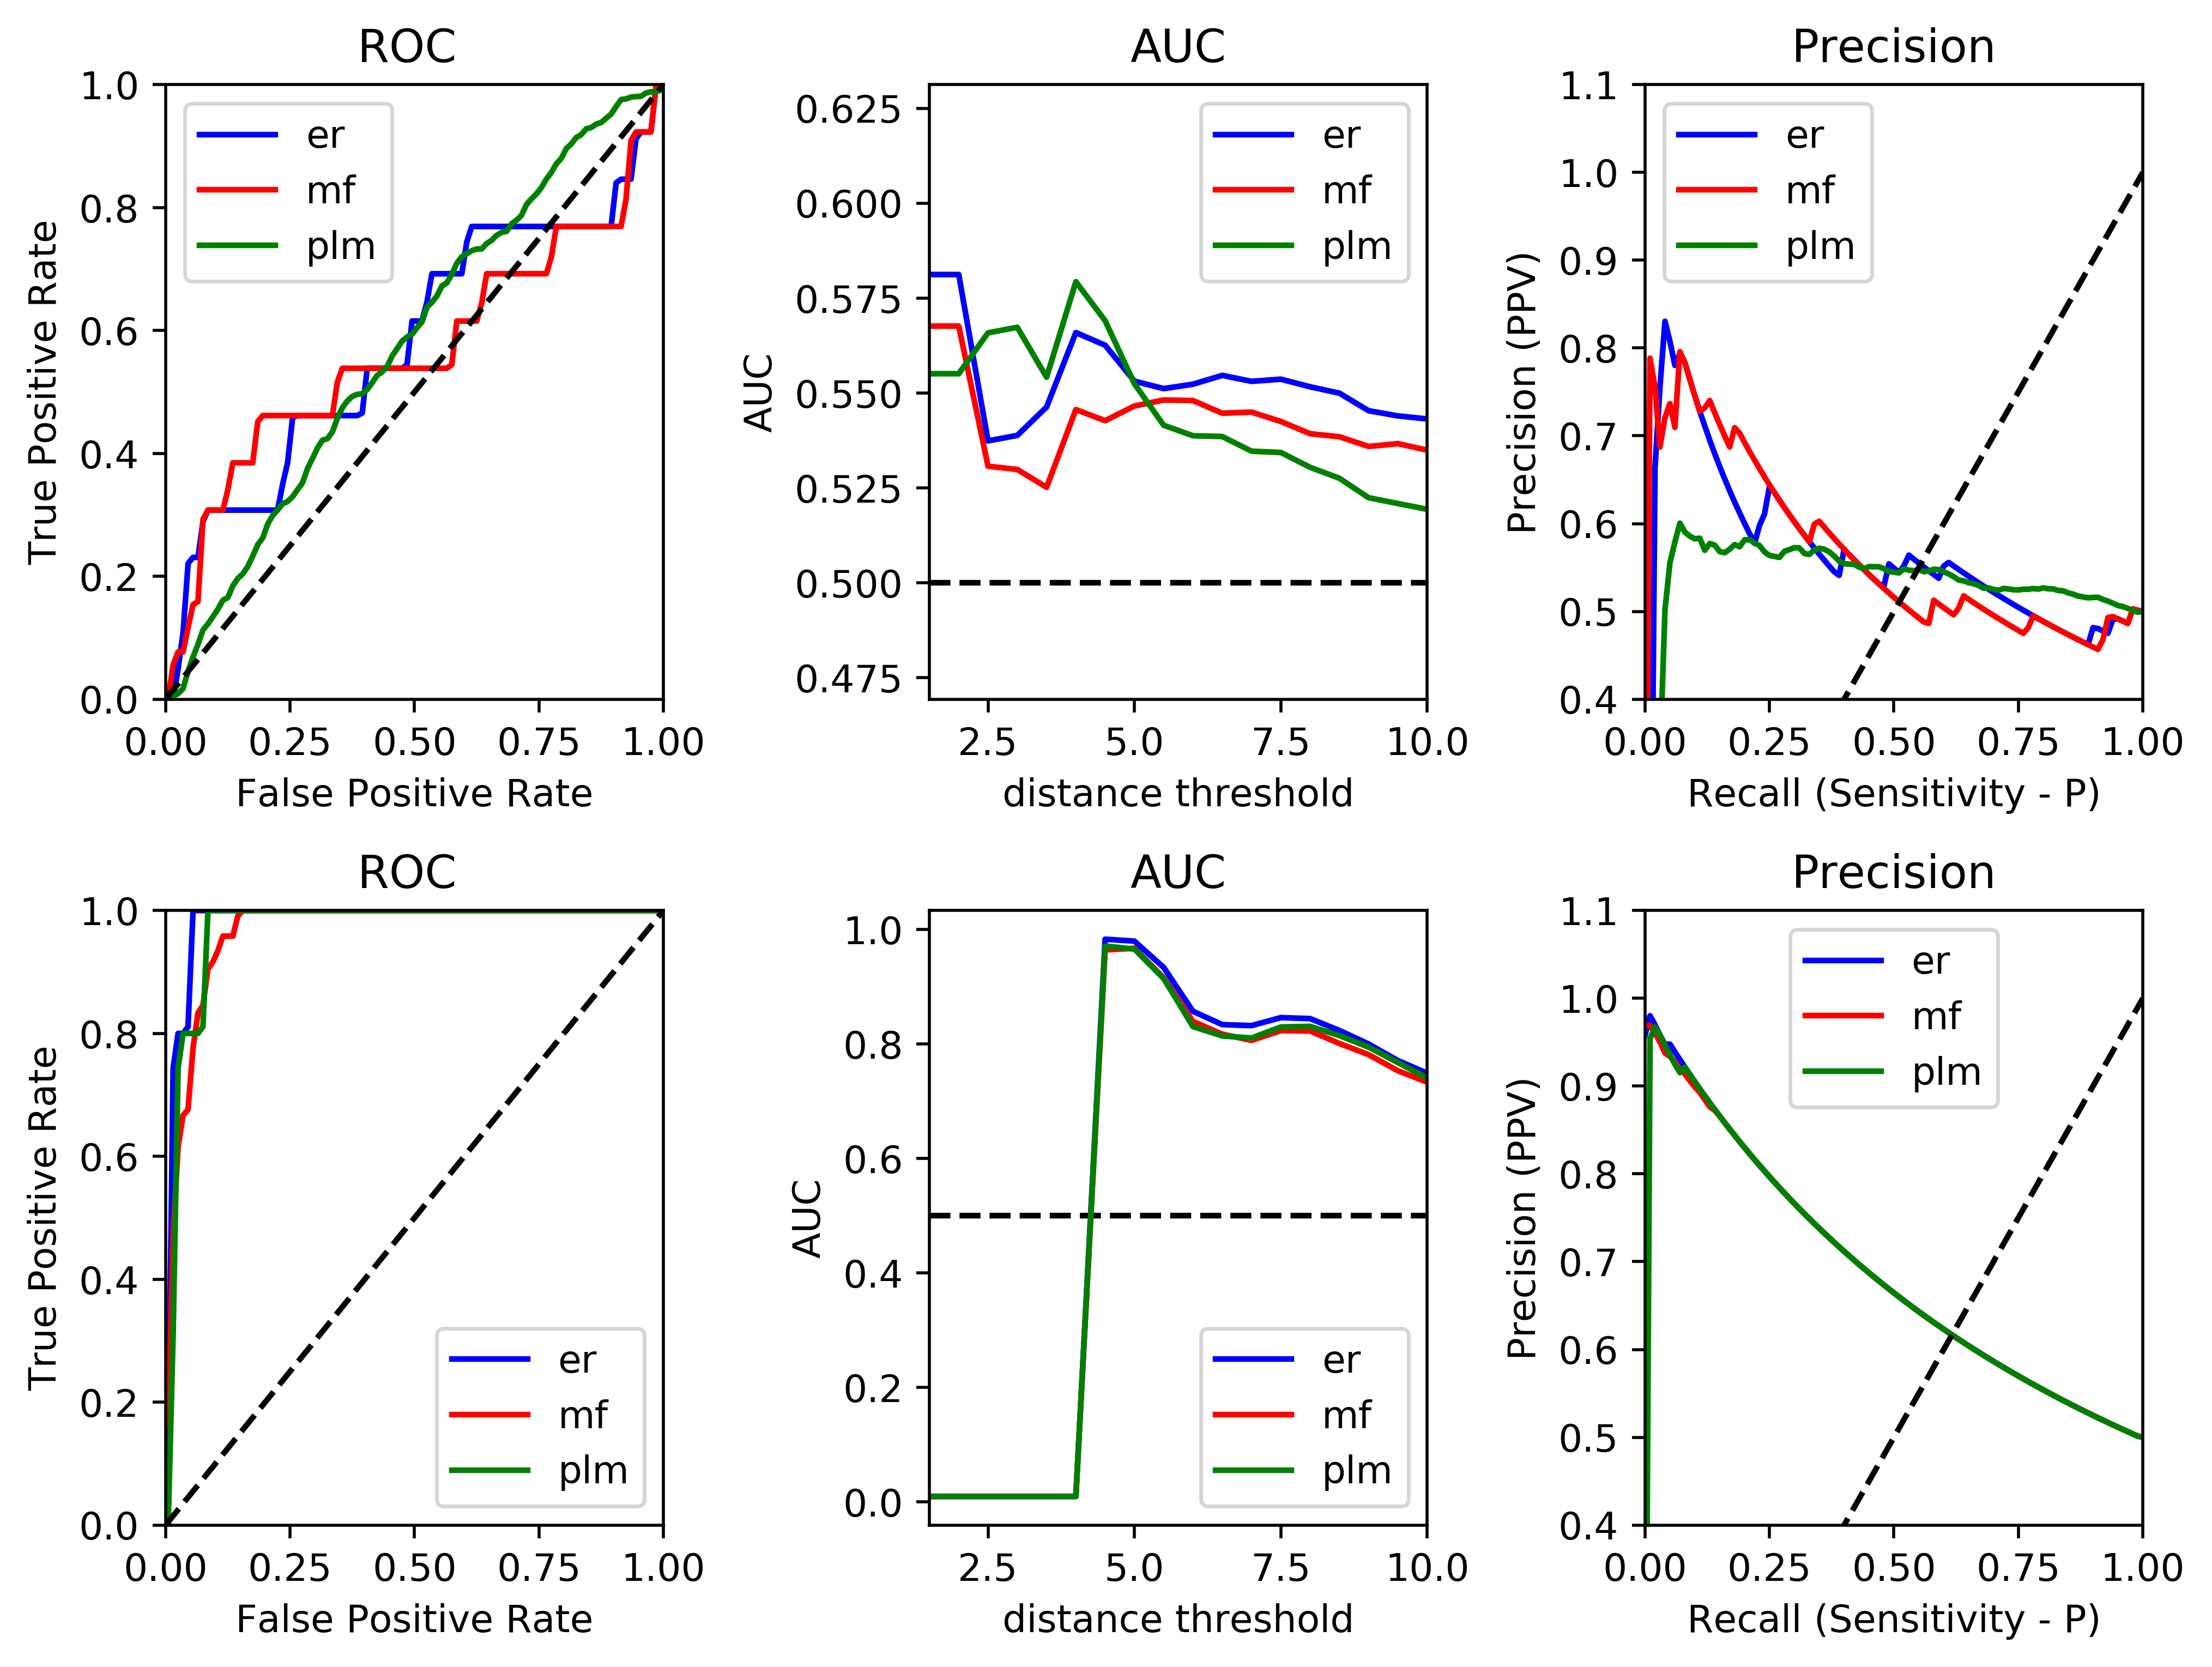

In [19]:
# Plot ROC for optimal DCA vs optimal ER
print("Optimal Contact threshold for (mf, er, plm) = (%f, %f, %f)"%(ct_thres[i0_mf],ct_thres[i0_er],ct_thres[i0_plm]))
print("Maximal AUC for (mf, er, plm) = (%f, %f, %f)"%(auc_mf[i0_mf], auc_er[i0_er], auc_plm[i0_plm]))
import matplotlib.gridspec as gridspec


#------------Old Contact Curves ------------#
fig = plt.figure(constrained_layout=True,figsize=(8, 6), dpi=500)
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

axROC1 = fig.add_subplot(spec[0,0])
axROC1.set_title('ROC ')
axROC1.plot(fp0_old_er,tp0_old_er,'b-',label="er")
axROC1.plot(fp0_old_mf,tp0_old_mf,'r-',label="mf")
axROC1.plot(fp0_old_plm,tp0_old_plm,'g-',label="plm")
axROC1.plot([0,1],[0,1],'k--')
axROC1.set_xlim([0,1])
axROC1.set_ylim([0,1])
axROC1.set_xlabel('False Positive Rate')
axROC1.set_ylabel('True Positive Rate')
axROC1.legend()

# Plot AUC 
axAUC1 = fig.add_subplot(spec[0,1])
axAUC1.set_title('AUC')
axAUC1.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
axAUC1.plot(ct_thres,auc_old_er,'b-',label="er")
axAUC1.plot(ct_thres,auc_old_mf,'r-',label="mf")
axAUC1.plot(ct_thres,auc_old_plm,'g-',label="plm")
axAUC1.set_ylim([min(auc_old_er.min(),auc_old_mf.min(),auc_old_plm.min())-0.05,max(auc_old_er.max(),auc_old_mf.max(),auc_old_plm.max())+0.05])
axAUC1.set_xlim([ct_thres.min(),ct_thres.max()])
axAUC1.set_xlabel('distance threshold')
axAUC1.set_ylabel('AUC')
axAUC1.legend()

# Plot Precision 
axPR1 = fig.add_subplot(spec[0,2])
axPR1.set_title('Precision')
axPR1.plot( p0_old_er,tp0_old_er / (tp0_old_er + fp0_old_er),'b-',label='er')
axPR1.plot( p0_old_mf,tp0_old_mf / (tp0_old_mf + fp0_old_mf),'r-',label='mf')
axPR1.plot( p0_old_plm,tp0_old_plm / (tp0_old_plm + fp0_old_plm),'g-',label='plm')
axPR1.plot([0,1],[0,1],'k--')
axPR1.set_xlim([0,1])
#plt.ylim([0,1])
axPR1.set_ylim([.4,1.1])
axPR1.set_xlabel('Recall (Sensitivity - P)')
axPR1.set_ylabel('Precision (PPV)')
axPR1.legend()

#------------New Contact Curves ------------#
axROC1 = fig.add_subplot(spec[1,0])
axROC1.set_title('ROC ')
axROC1.plot(fp0_er,tp0_er,'b-',label="er")
axROC1.plot(fp0_mf,tp0_mf,'r-',label="mf")
axROC1.plot(fp0_plm,tp0_plm,'g-',label="plm")
axROC1.plot([0,1],[0,1],'k--')
axROC1.set_xlim([0,1])
axROC1.set_ylim([0,1])
axROC1.set_xlabel('False Positive Rate')
axROC1.set_ylabel('True Positive Rate')
axROC1.legend()

# Plot AUC 
axAUC1 = fig.add_subplot(spec[1,1])
axAUC1.set_title('AUC')
axAUC1.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
axAUC1.plot(ct_thres,auc_er,'b-',label="er")
axAUC1.plot(ct_thres,auc_mf,'r-',label="mf")
axAUC1.plot(ct_thres,auc_plm,'g-',label="plm")
axAUC1.set_ylim([min(auc_er.min(),auc_mf.min(),auc_plm.min())-0.05,max(auc_er.max(),auc_mf.max(),auc_plm.max())+0.05])
axAUC1.set_xlim([ct_thres.min(),ct_thres.max()])
axAUC1.set_xlabel('distance threshold')
axAUC1.set_ylabel('AUC')
axAUC1.legend()

# Plot Precision 
axPR1 = fig.add_subplot(spec[1,2])
axPR1.set_title('Precision')
axPR1.plot( p0_er,tp0_er / (tp0_er + fp0_er),'b-',label='er')
axPR1.plot( p0_mf,tp0_mf / (tp0_mf + fp0_mf),'r-',label='mf')
axPR1.plot( p0_plm,tp0_plm / (tp0_plm + fp0_plm),'g-',label='plm')
axPR1.plot([0,1],[0,1],'k--')
axPR1.set_xlim([0,1])
#plt.ylim([0,1])
axPR1.set_ylim([.4,1.1])
axPR1.set_xlabel('Recall (Sensitivity - P)')
axPR1.set_ylabel('Precision (PPV)')
axPR1.legend()



tools.hide_toggle()

Dimensions of DI Pairs:
ER:  9453
PLM:  9316
MF:  9316



	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


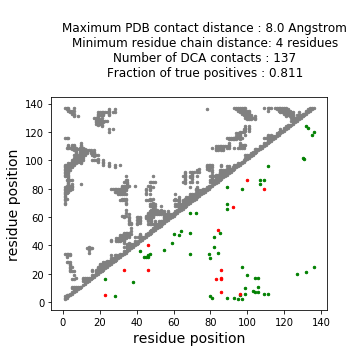


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


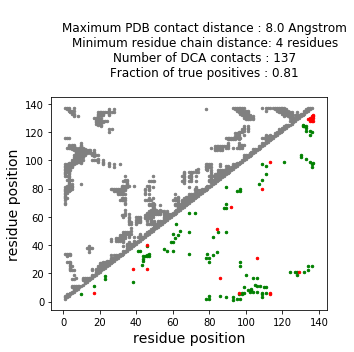


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


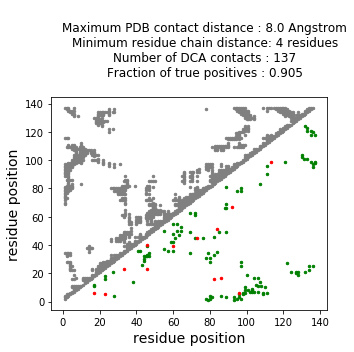


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


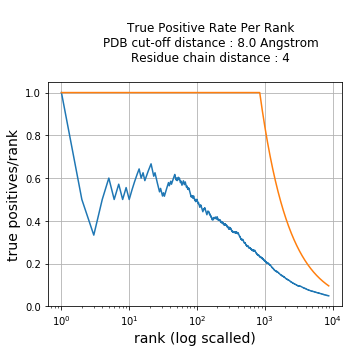


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


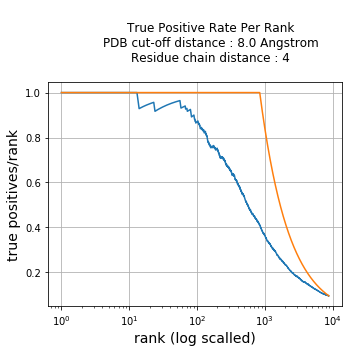


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


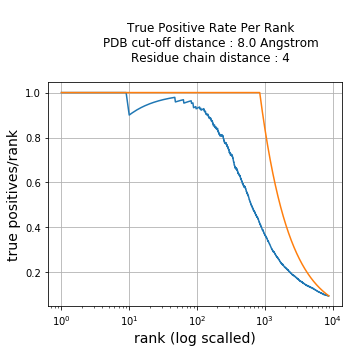

In [23]:
# Using PYDCA contact mapping module
print("Dimensions of DI Pairs:")
print("ER: ",len(sorted_DI_er))
print("PLM: ",len(sorted_DI_plm))
print("MF: ",len(sorted_DI_mf))


erdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_er,
    linear_dist = 4,
    contact_dist = 8.0,
)

mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_mf,
    linear_dist = 4,
    contact_dist = 8.0,
)

plmdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_plm,
    linear_dist = 4,
    contact_dist = 8.0,
)

er_contact_map_data = erdca_visualizer.plot_contact_map()
mf_contact_map_data = mfdca_visualizer.plot_contact_map()
plm_contact_map_data = plmdca_visualizer.plot_contact_map()

er_tp_rate_data = erdca_visualizer.plot_true_positive_rates()
mf_tp_rate_data = mfdca_visualizer.plot_true_positive_rates()
plm_tp_rate_data = plmdca_visualizer.plot_true_positive_rates()

tools.hide_toggle()